# Bank Churn Prediction

The Bank Churn Prediction project aims to identify customers who are at risk of leaving the bank.
Using features such as gender, age, account balance, activity level, credit score, tenure, and geography, the model learns patterns in the data and predicts the probability that a customer will churn.

This allows the bank to:

- better understand which factors influence customer attrition,

- focus retention efforts on clients who are most likely to leave,

- design more personalized communication and targeted offers.

As a result, the bank can reduce customer loss, improve customer satisfaction, and optimize its marketing and operational strategies. Ultimately, customers become more satisfied, and the bank strengthens its position while also attracting new clients.

This project covers practical, real-world aspects of data science and helps develop a deeper understanding of business logic.
By working with churn prediction, the analysis goes beyond modeling itself and focuses on how data-driven insights support strategic decisions, customer retention, and long-term business value.

In [87]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [10]:
#Loading the dataset
clients_data = pd.read_csv('../data/Bank_Churn.csv')
clients_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
#Displaying the full description without truncation ("...")
pd.set_option('display.max_colwidth', None)

In [12]:
#Columns name with description
cols_description = pd.read_csv('../data/Bank_Churn_Data_Dictionary.csv')
cols_description

,Field,Description
0,CustomerId,A unique identifier for each customer
1,Surname,The customer's last name
2,CreditScore,A numerical value representing the customer's credit score
3,Geography,"The country where the customer resides (France, Spain or Germany)"
4,Gender,The customer's gender (Male or Female)
5,Age,The customer's age
6,Tenure,The number of years the customer has been with the bank
7,Balance,The customer's account balance
8,NumOfProducts,"The number of bank products the customer uses (e.g., savings account, credit card)"
9,HasCrCard,"Whether the customer has a credit card (1 = yes, 0 = no)"


## Data preprocessing

In [13]:
#Checking the structure of our dataset
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [14]:
# Checking descriptive statistics
clients_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
#Checking missing values
clients_data.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [16]:
clients_data.duplicated().sum()

np.int64(0)

The dataset contains no missing values and no duplicates

In [17]:
#Remove irrelevant columns
data = clients_data.drop(['CustomerId', 'Surname'], axis=1, errors='ignore').copy()

In [18]:
#Encode categorical features using one-hot encoding
data_enc = pd.get_dummies(data, columns=['Geography', 'Gender']).copy()

In [19]:
data_enc.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False


In [20]:
#Function detecting outliers
def detect_outliers(dataset, columns):
    Q1 = dataset[columns].quantile(0.25)
    Q3 = dataset[columns].quantile(0.75)
    IQR = Q3 - Q1

    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR

    outliers = dataset[(dataset[columns] < Q1 - 1.5*IQR) | (dataset[columns] > Q3 + 1.5*IQR)]
    return outliers, low, up

## Exploratory Data Analysis

CreditScore:
Number of outliers 15
      CreditScore
7             376
942           376
1193          363
Age:
Number of outliers 359
     Age
58    66
85    75
104   65
Balance:
Number of outliers 0
EstimatedSalary:
Number of outliers 0


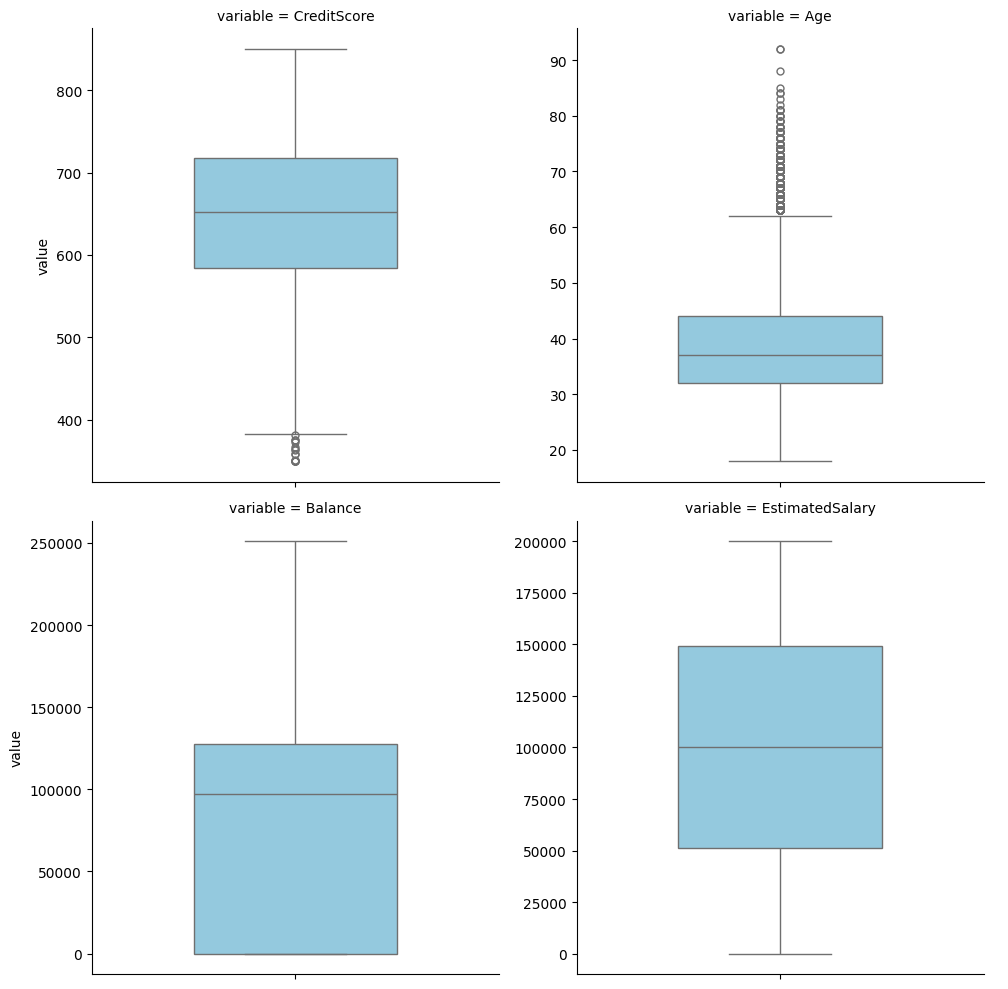

In [70]:
# Outlier visualization with separate boxplots
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in columns:
    outliers, low, up = detect_outliers(data_enc, col)
    print(f'{col}:')
    print(f'Number of outliers {outliers.shape[0]}')
    if outliers.shape[0] != 0:
        print(outliers[[col]].head(3))
    else:
        continue

#if not os.path.exists('images'):
#    os.makedirs('images')

#Displaying boxplots 
sns.catplot(
           kind='box',
           data=clients_data[columns].melt(),
           y='value',
           col="variable",
           col_wrap=2,
           sharey=False,
           color='skyblue',
           width=0.5
)
plt.savefig('../images/Boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

The boxplots visualize the distributions of four variables: CreditScore, Age, Balance, and EstimatedSalary. **CreditScore** is fairly symmetric around 650 but contains some low-value outliers. Notably, **Age** is right-skewed with a median around 37 and significant high-value outliers, indicating a generally younger demographic with a tail of older individuals. **Balance** variable shows a wide spread, and the fact that the bottom of the box touches zero suggests that a significant portion of the dataset has a balance of 0 but a median almost total 100,000. Finally, the **EstimatedSalary** appears very uniformly distributed with a median also near 100,000. The last two variables have no outliers.

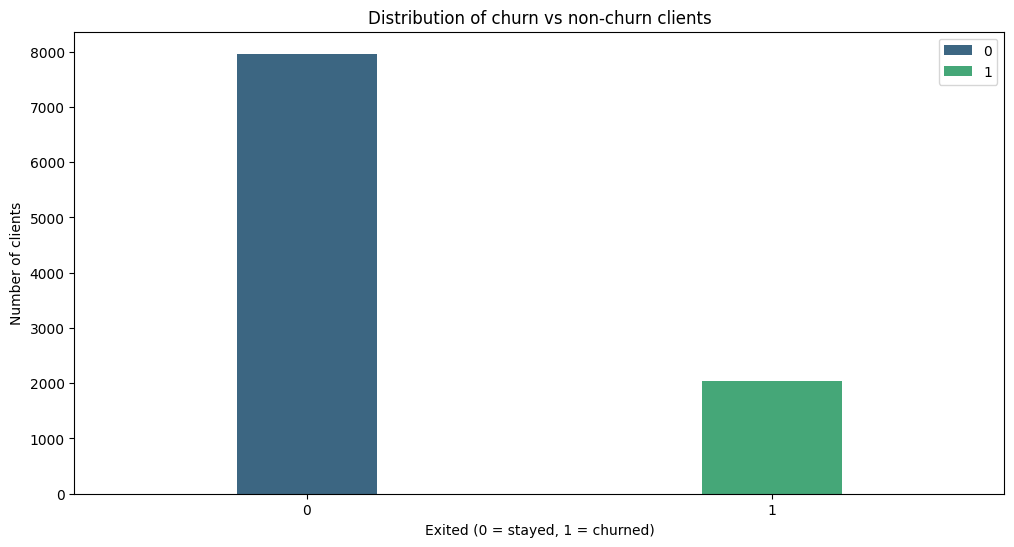

In [67]:
#Displaying barplots of clients who churned and stayed
exit_counter = data_enc.groupby('Exited').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=exit_counter.index, y=exit_counter.values, hue=exit_counter.index, width=0.3, palette='viridis')
plt.title('Distribution of churn vs non-churn clients')
plt.xlabel('Exited (0 = stayed, 1 = churned)')
plt.ylabel('Number of clients')
plt.legend()
plt.savefig('../images/Distribution_churn_vs_not_churn.png', dpi=300, bbox_inches='tight')
plt.show()

The barplot clearly shows a strong imbalance between clients who stayed and those who churned.
The dark blue bar represents customers who remained with the bank — approximately 8,000 clients.
In contrast, the green bar shows that only about 2,000 clients churned, which is roughly four times fewer.

Such a significant class imbalance can create challenges in the predictive modeling stage. A model trained on imbalanced data may learn to predict only the majority class (clients who stay) while failing to correctly identify the minority class (clients who churn).

It will be necessary to:

1. Apply resampling techniques, such as SMOTE or Random Over/Undersampling.

2. Perform appropriate feature scaling (e.g., StandardScaler or MinMaxScaler) depending on the models used.

3. Rely on evaluation metrics better suited for imbalanced classification, such as:

- Recall

- Precision

- F1-Score

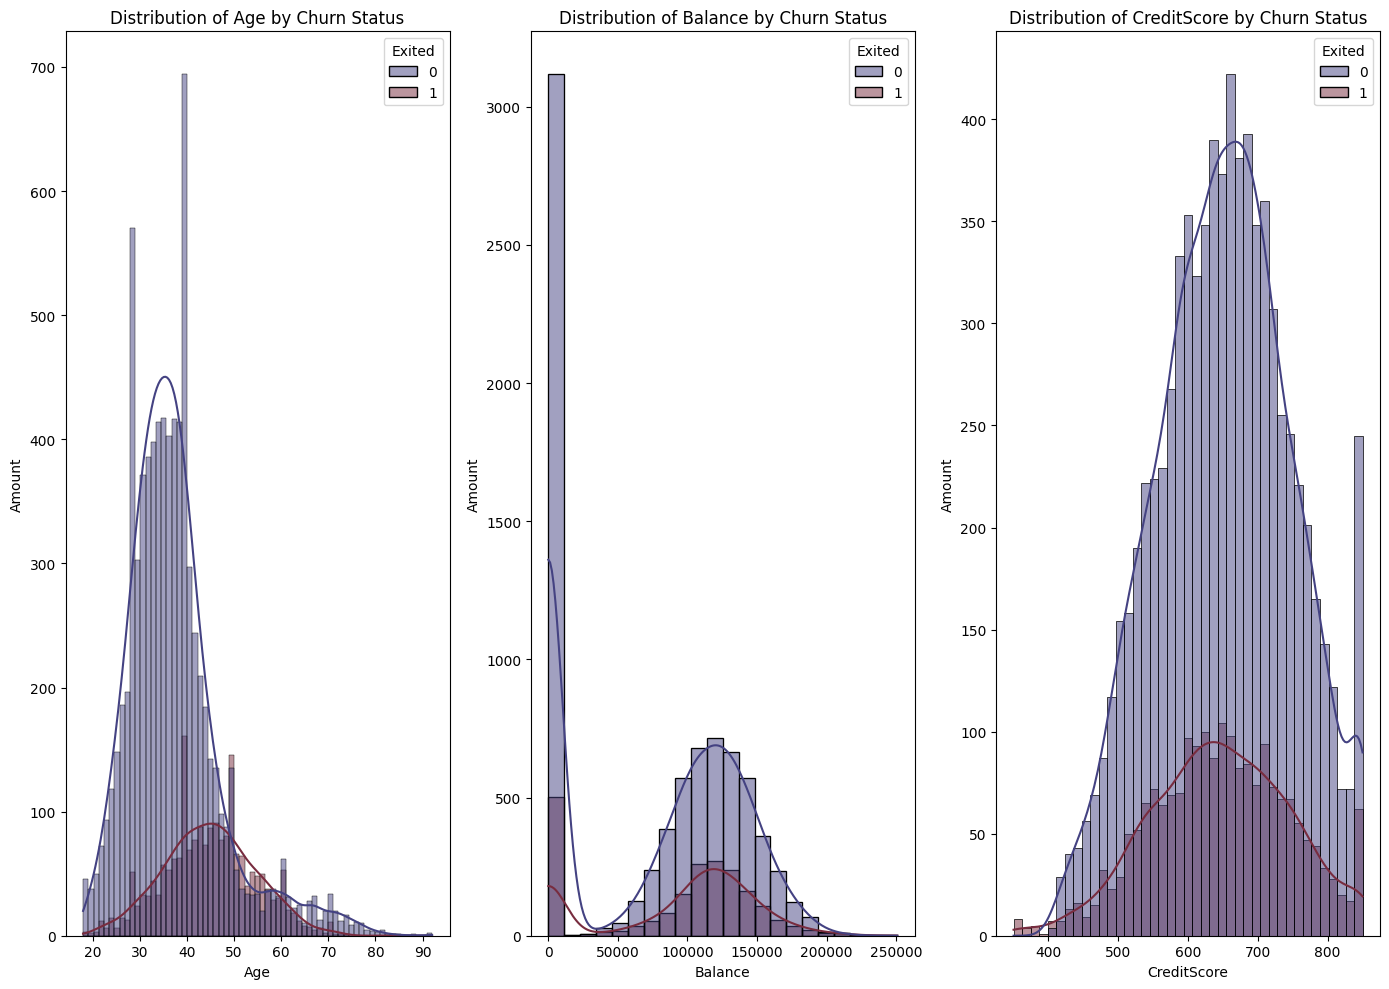

In [68]:
#Numerical values to churn - histplots
fig, axes = plt.subplots(1, 3, figsize=(14, 10))

sns.histplot(data=data_enc, x='Age', hue='Exited', kde=True, palette='icefire', ax=axes[0])
axes[0].set_title('Distribution of Age by Churn Status')
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Amount")

sns.histplot(data=data_enc, x='Balance', hue='Exited', kde=True, palette='icefire', ax=axes[1])
axes[1].set_title('Distribution of Balance by Churn Status')
axes[1].set_xlabel("Balance")
axes[1].set_ylabel("Amount")

sns.histplot(data=data_enc, x='CreditScore', hue='Exited', kde=True, palette='icefire', ax=axes[2])
axes[2].set_title('Distribution of CreditScore by Churn Status')
axes[2].set_xlabel("CreditScore")
axes[2].set_ylabel("Amount")

plt.tight_layout()
plt.savefig('../images/Numerical_values_histplots.png', dpi=300, bbox_inches='tight')
plt.show()

1. **Age**:

The distribution of non-churned clients (blue) is right-skewed, peaking significantly between ages 30 and 35. In contrast, the distribution of churned clients (red) is closer to a normal distribution, with a peak around ages 45 to 50. This suggests that older clients may be more prone to churn.

2. **Balance**:

The most striking feature is the massive spike at zero balance, indicating that a large proportion of clients maintain no balance on their accounts. Notably, these zero-balance clients are significantly less likely to churn compared to those with positive balances. For clients with balance above zero, the distributions are quite similar between churned and non-churned groups. This insight suggests that clients who maintain account balances are more vulnerable to churn, making them a priority for retention efforts.

3. **Credit Score**:

The distributions for churned (red) and non-churned (blue) clients are nearly identical, both exhibiting a bell-shaped curve centered around credit scores of 600–700. Since the curves overlap almost perfectly, credit score does not appear to be a strong predictor of churn behavior.

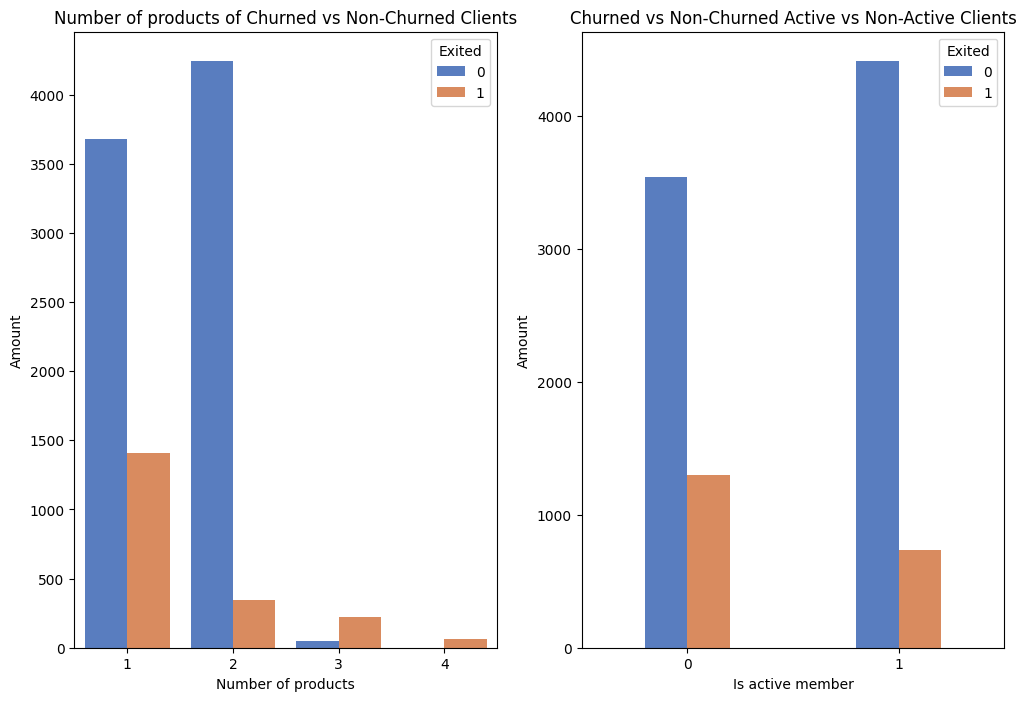

In [71]:
#Barplots with number of products and wheather the member is active

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 8))

sns.countplot(data=data_enc, x='NumOfProducts', hue='Exited', ax=axes2[0], palette='muted')
axes2[0].set_title('Number of products of Churned vs Non-Churned Clients')
axes2[0].set_xlabel('Number of products')
axes2[0].set_ylabel('Amount')

sns.countplot(data=data_enc, x='IsActiveMember', hue='Exited', ax=axes2[1], palette='muted', width=0.4)
axes2[1].set_title('Churned vs Non-Churned Active vs Non-Active Clients')
axes2[1].set_xlabel('Is active member')
axes2[1].set_ylabel('Amount')

plt.savefig('../images/Number_of_products_and_active_clients_countplots.png', dpi=300, bbox_inches='tight')
plt.show()

The chart on the left reveals a significant correlation between product ownership and churn. Clients holding a single product are highly susceptible to attrition, as evidenced by the substantial size of the orange bar.

In contrast, the group with two products represents the 'sweet spot' for retention, demonstrating the highest loyalty and lowest churn rate.

Interestingly, this trend reverses for product-heavy clients: those with 3 products show a high exit rate, while retention for those with 4 products is near zero. 

**Conclusion**: Excessive product ownership correlates with higher churn risk, whereas the 2-product segment represents the most stable and satisfied customer base.

The second chart indicates that non-active members are more prone to churn; the ratio of clients who left versus those who stayed is clearly unfavorable in this group.

Among active members, the number of clients who stayed (blue bar) increased compared to non-active members, while the number of those who churned (salmon bar) decreased significantly.

**Conclusion**: Low activity is a strong risk factor. The bank should prioritize re-engagement strategies for non-active members to reduce attrition.

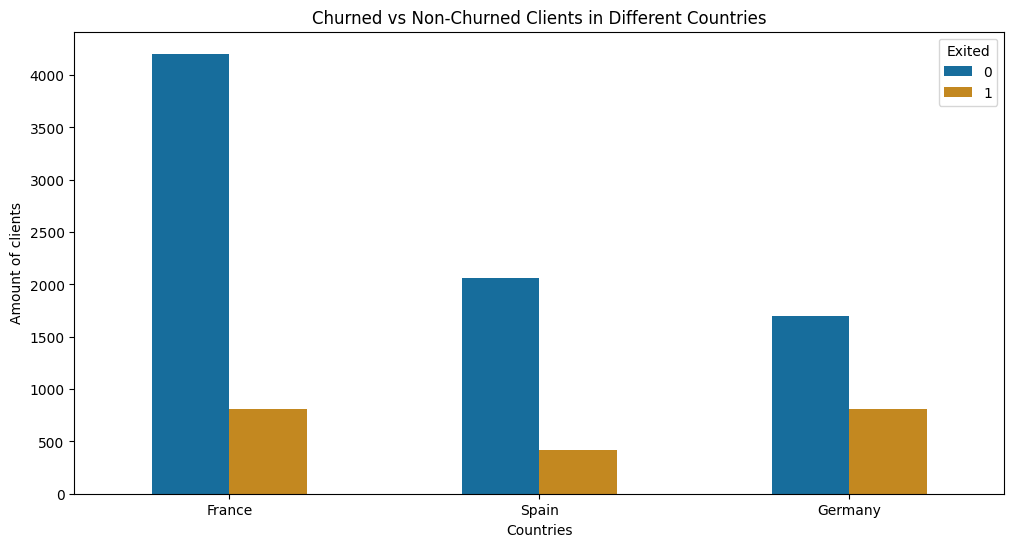

In [72]:
#How geography affects on clients decisions

plt.figure(figsize=(12, 6))
sns.countplot(data=clients_data, x='Geography', hue='Exited', palette='colorblind', width=0.5)
plt.title('Churned vs Non-Churned Clients in Different Countries')
plt.xlabel('Countries')
plt.ylabel('Amount of clients')
plt.savefig('../images/Geographical_influence_countplots.png', dpi=300, bbox_inches='tight')
plt.show()

The chart illustrates customer churn status across different countries. France leads in total membership, with over 4,000 retained clients and approximately 800 who churned. Spain has a customer base roughly half the size of France, with fewer than 500 exits. Interestingly, Germany exhibits the most unfavorable retention ratio; despite having the smallest number of retained clients, it has a disproportionately high number of customers who churned.

To sum up, France is the bank's largest market, accounting for the majority of the customer base with a relatively stable retention rate. In contrast, Germany presents a significant challenge, as it shows a disproportionately high churn rate despite having the smallest number of retained clients, suggesting underlying issues specific to that region. Spain occupies a middle ground, with a smaller market share than France but a healthier retention ratio than Germany.

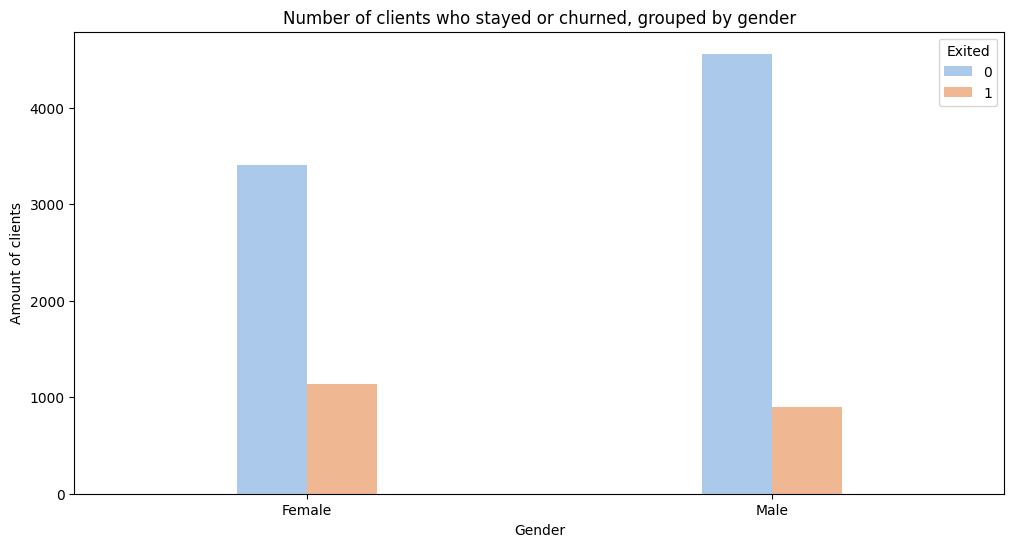

In [73]:
#Number of clients who stayed or churned, grouped by gender

plt.figure(figsize=(12, 6))
sns.countplot(data=clients_data, x='Gender', hue='Exited', palette='pastel', width=0.3)
plt.title('Number of clients who stayed or churned, grouped by gender')
plt.xlabel('Gender')
plt.ylabel('Amount of clients')
plt.savefig('../images/Clients_by_gender_countplot.png', dpi=300, bbox_inches='tight')
plt.show()

These bar plots show that there are slightly more male clients (around 4,500), while the number of female clients is approximately 1000 lower. It is worth noting that although the bank has more male clients, males are less likely to churn compared to females. 

This suggests that the female segment may be more vulnerable to churn. Therefore, it could be beneficial for the bank to focus on this minority group and explore strategies to increase their retention.

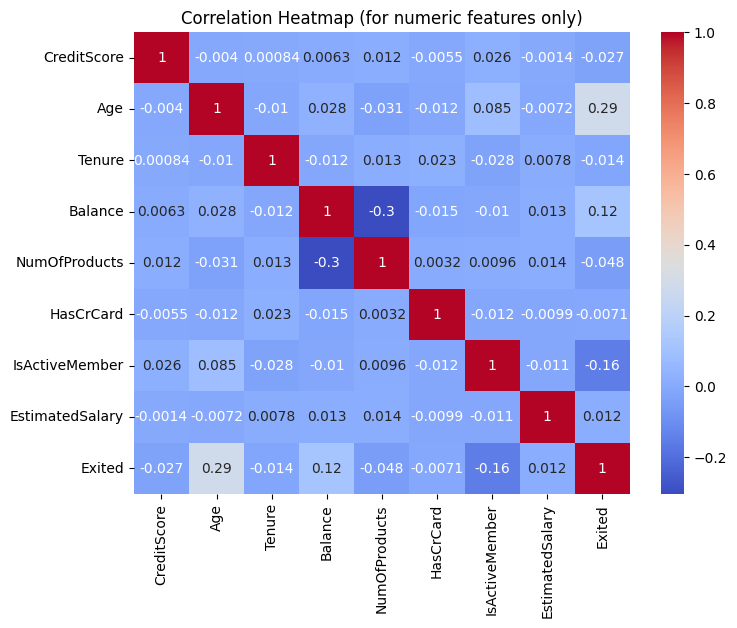

In [74]:
#Heatmap of numerical values

numeric_cols = data_enc.select_dtypes(include=['int64', 'float64'])
corr = numeric_cols.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (for numeric features only)')
plt.savefig('../images/Numerical_values_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

The heatmap illustrates the Pearson correlation coefficients between numerical features. Coefficients approaching 1 denote a strong positive correlation, whereas those approaching -0.3 denote a strong negative correlation.

The most significant predictor of the target variable ('Exited') is 'Age', with a coefficient of 0.29. A weak positive correlation is also observed between 'Balance' and 'Exited'. 'CreditScore', however, exhibits a negligible negative correlation.

These metrics corroborate the insights from the distribution plots, confirming that Credit Score has minimal predictive power regarding customer attrition. On the other hand, 'Age' and 'Balance' show a stronger correlation with churn and should be used to drive the bank's new strategic initiatives.

## Model Building

In [28]:
#Selecting features
X = data_enc.drop('Exited', axis=1)
y = data_enc['Exited']

In [29]:
#Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [30]:
#Scaling to balance the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
#Using the SMOTE technique to handle the class imbalance problem
smote = SMOTE(random_state=42)

#Only using on train set
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### First Model - Logistic Regression

In [32]:
#Setting hyperparameters to improve model performance
param_log = {
    'C': [0.01, 0.1, 0.5, 1.0, 2.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [33]:
#Using LogisticRegression
log_model = LogisticRegression()

In [34]:
grid_log = GridSearchCV(log_model, param_log, cv=5, n_jobs=-1, scoring='f1')

In [35]:
#Training model
grid_log.fit(X_train_smote, y_train_smote)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [36]:
best_log_model = grid_log.best_estimator_

#Prediction
log_model_predict = best_log_model.predict(X_test_scaled)

#Predicted probability for class 1
log_model_predict_proba = best_log_model.predict_proba(X_test_scaled)[:, 1]

In [37]:
#Exploring model coefficients
coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': best_log_model.coef_[0]
})

print(coeffs)

              Feature    Weight
0         CreditScore -0.052334
1                 Age  0.795034
2              Tenure  0.000000
3             Balance  0.129255
4       NumOfProducts -0.055393
5           HasCrCard  0.000000
6      IsActiveMember -0.394222
7     EstimatedSalary  0.013995
8    Geography_France  0.000000
9   Geography_Germany  0.284922
10    Geography_Spain  0.000000
11      Gender_Female  0.002055
12        Gender_Male -0.213310


From the table above, we can see that the features most associated with increased churn are Age, Balance, EstimatedSalary, and customers from Germany and Spain.

From the EDA charts, these results align with expectations:

- Age is the strongest indicator of churn, while Balance also contributes but to a lesser extent. Together, these features help the model identify clients who are more likely to leave.

- EstimatedSalary and Gender_Female have a smaller impact on churn.

- Geography_Germany appears particularly important, which is consistent with the “Churned vs Non-Churned Clients by Country” chart.

This insight suggests that retention strategies could focus on older clients with higher balances, and special attention might be needed for clients in Germany, while Spanish and France clients are less critical factors.

In [38]:
classification_report(y_test, log_model_predict, output_dict=True)

{'0': {'precision': 0.9125412541254125,
  'recall': 0.7013316423589093,
  'f1-score': 0.793115812119039,
  'support': 1577.0},
 '1': {'precision': 0.4022842639593909,
  'recall': 0.7494089834515366,
  'f1-score': 0.523534269199009,
  'support': 423.0},
 'accuracy': 0.7115,
 'macro avg': {'precision': 0.6574127590424017,
  'recall': 0.7253703129052229,
  'f1-score': 0.658325040659024,
  'support': 2000.0},
 'weighted avg': {'precision': 0.804621900705299,
  'recall': 0.7115,
  'f1-score': 0.7360993157914527,
  'support': 2000.0}}

In [39]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, log_model_predict_proba):.4f}")

ROC-AUC Score: 0.7923


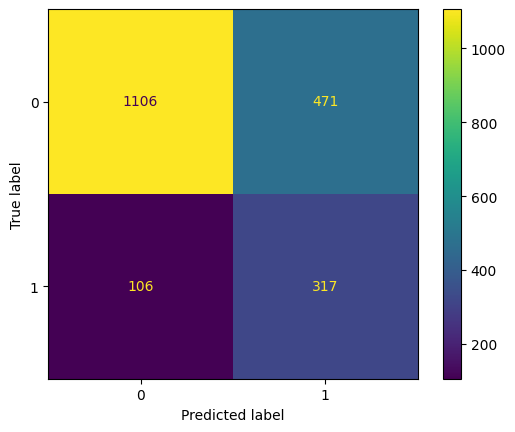

In [75]:
ConfusionMatrixDisplay.from_estimator(best_log_model, X_test_scaled, y_test)
plt.savefig('../images/Confusion_Matrix_model1.png', dpi=300, bbox_inches='tight')

The model achieved the highest Recall (75%), successfully identifying 317 out of 423 churners (missing only 106). However, the Precision remains low at 40%. The Confusion Matrix reveals a high number of False Positives (471), which means that for every 10 customers flagged as 'at risk,' 6 are actually loyal.

The relatively low F1-score (~0.52) suggests that the relationships in the dataset are non-linear, which this linear model struggles to capture. Consequently, the model adopted an 'aggressive' prediction strategy, prioritizing high Recall at the expense of Precision.

The ROC-AUC score of 0.7923 indicates that, despite its limitations in Precision, the model still has a solid ability to rank customers by churn risk. It can separate churners from non-churners significantly better than random guessing, even if the final classification threshold leads to many False Positives.

Conclusion: Due to its high False Positive rate, this model is suitable only for low-cost retention campaigns, where mistakenly targeting a loyal customer carries a negligible financial cost.

## Second Model - Random Forest

In [41]:
#Setting some hyperparameters for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [42]:
#Using Random Forest Classifier
rfc_model = RandomForestClassifier(random_state=42)

In [43]:
grid_search = GridSearchCV(rfc_model, param_grid, cv=3, scoring='f1', n_jobs=-1)

#Training model to fit best parameters

In [44]:
grid_search.fit(X_train_smote, y_train_smote)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [45]:
#Model best parameters
grid_search.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [46]:
rfc_updated = RandomForestClassifier(n_estimators=300, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)

In [47]:
#Training model with best parameters
rfc_updated.fit(X_train_smote, y_train_smote)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
rfc_model_pred = rfc_updated.predict(X_test_scaled)

rfc_model_pred_proba = rfc_updated.predict_proba(X_test_scaled)[:, 1]

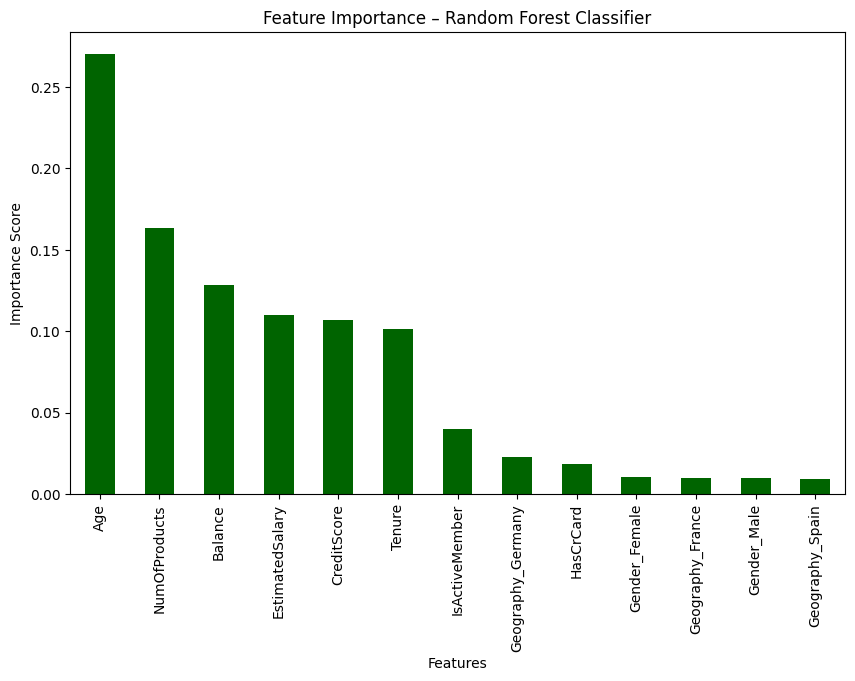

In [76]:
#Features importance
rfc_importances = rfc_updated.feature_importances_
features_rfc = pd.Series(rfc_importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
features_rfc.plot(kind='bar', color='darkgreen')
plt.title('Feature Importance – Random Forest Classifier')
plt.xlabel('Features')
plt.ylabel('Importance Score')

plt.savefig('../images/Feature_importance_model2.png', dpi=300, bbox_inches='tight')
plt.show()

The Feature Importance plot reveals exactly what drives the model's decisions. This confirms that the relationships are non-linear, which is why this tree-based model outperformed linear regression.

Dominant Factors:

- Age: This is by far the strongest predictor. As seen in the EDA, older customers are much more likely to churn.

- NumOfProducts: The second most critical feature. This validates the finding that customers with 3 or 4 products have a very high churn rate.

- Balance: Financial status plays a major role, likely differentiating between active/high-value clients and dormant ones.

Geography & Gender: These are the least important features for the Random Forest model. The model relies more on behavioral and financial metrics than on demographics.

In [50]:
classification_report(y_test, rfc_model_pred, output_dict=True)

{'0': {'precision': 0.9042071197411004,
  'recall': 0.885859226379201,
  'f1-score': 0.8949391415759129,
  'support': 1577.0},
 '1': {'precision': 0.6043956043956044,
  'recall': 0.6501182033096927,
  'f1-score': 0.6264236902050114,
  'support': 423.0},
 'accuracy': 0.836,
 'macro avg': {'precision': 0.7543013620683523,
  'recall': 0.7679887148444469,
  'f1-score': 0.7606814158904622,
  'support': 2000.0},
 'weighted avg': {'precision': 0.840796984245528,
  'recall': 0.836,
  'f1-score': 0.8381481236109674,
  'support': 2000.0}}

In [51]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_model_pred_proba):.4f}")

ROC-AUC Score: 0.8729


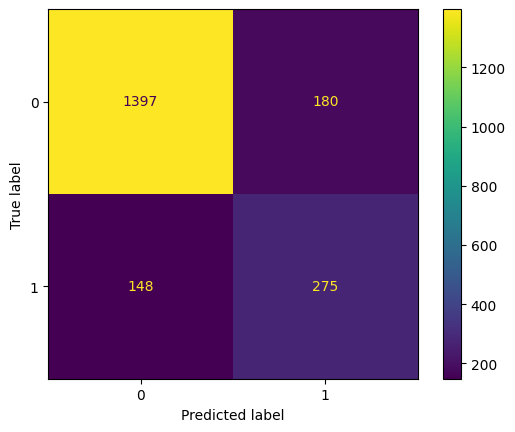

In [77]:
ConfusionMatrixDisplay.from_estimator(rfc_updated, X_test_scaled, y_test)
plt.savefig('../images/Confusion_Matrix_model2.png', dpi=300, bbox_inches='tight')
plt.show()

The final model prioritizes a balance between profitability and risk detection. Unlike the aggressive baseline, it significantly reduces False Positives, preventing resource wastage on loyal clients.

- Precision & F1-Score: Significantly improved (Precision: 40% $\rightarrow$ 60%, F1: 52% $\rightarrow$ 63%),

- Recall: Dropped by ~10% as a strategic trade-off for higher precision,

- ROC-AUC: Achieved 0.87, confirming the model's robust ability to distinguish churners from non-churners,

- Feature Importance: 'Age' and 'Balance' remain the top predictors, while the weight of 'Geography' has decreased.

Focus retention efforts on older customers and those with three or more products. The improved precision means you can offer more valuable incentives without heavily targeting loyal customers by mistake.

### Trzeci model - XGBoost

In [53]:
#Setting hyperparameters
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0.05, 0.1, 0.2, 0.5],
    'scale_pos_weight': [1, 2, 3, 4]
}

In [54]:
#Using XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

In [55]:
#Hyperparameter tuning
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    scoring='f1',
    n_iter=100,
    n_jobs=-1,
    cv=5,
    random_state=42
)

In [56]:
#Training model
random_search.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'gamma': [0.05, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'n_estimators': [100, 200, ...], 'scale_pos_weight': [1, 2, ...]}"
,n_iter,100
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
xgb_predict = random_search.predict(X_test)

xgb_model_pred_proba = random_search.predict_proba(X_test)[:, 1]

In [88]:
if not os.path.exists('../models'):
    os.makedirs('../models')

model_to_save = random_search.best_estimator_
joblib.dump(model_to_save, '../models/churn_xgboost_model.joblib')

['../models/churn_xgboost_model.joblib']

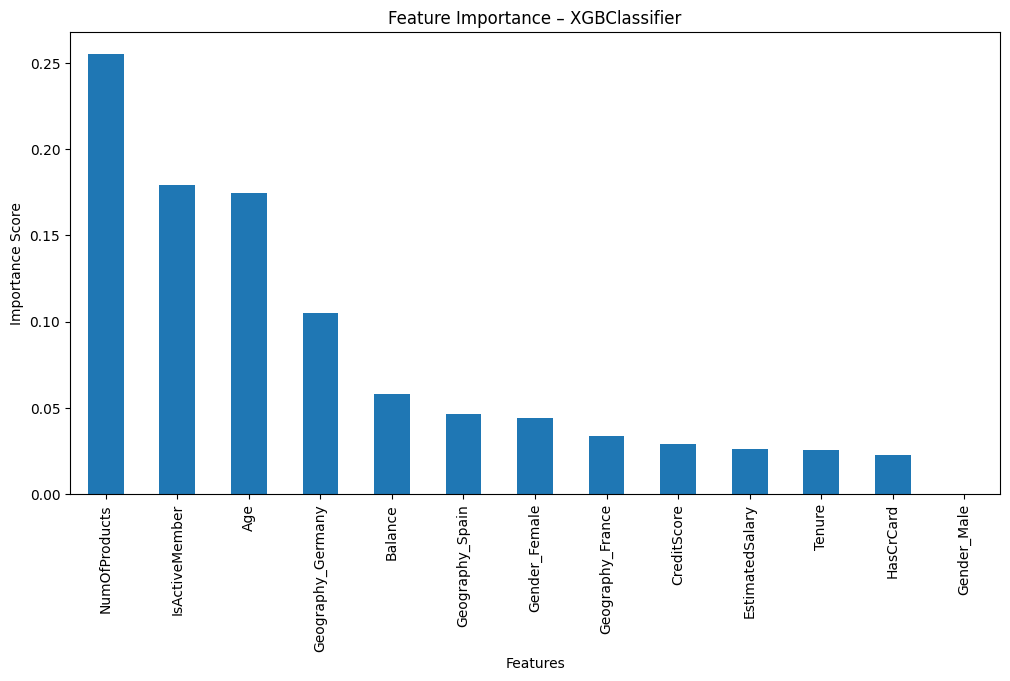

In [89]:
#Features importance for next model

best_xgb = random_search.best_estimator_
xgb_importances = best_xgb.feature_importances_
features_xgb = pd.Series(xgb_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
features_xgb.plot(kind='bar')
plt.title('Feature Importance – XGBClassifier')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.savefig('../images/Feature_importance_model3.png', dpi=200, bbox_inches='tight')
plt.show()

Feature Importance Shifts:

- 'NumOfProducts': Took the top spot (previously 2nd).

- 'IsActiveMember': Importance score increased ~4x, becoming a key driver.

- 'Age': Dropped to 3rd place, decreasing by ~0.15 points.

- Geography: Gained more predictive power compared to the previous model.

- Financials: 'CreditScore' and 'EstimatedSalary' are far less influential, dropping ~3x in importance.

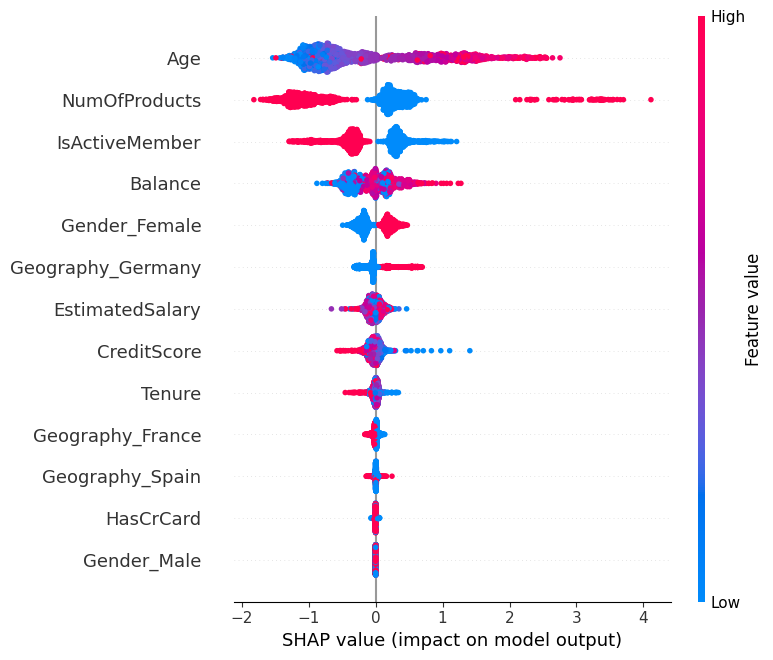

In [93]:
exp = shap.TreeExplainer(best_xgb)
shap_val = exp.shap_values(X_test)

shap.summary_plot(shap_val, X_test, show=False)

plt.savefig('../images/Feature_value_model3.png', dpi=300, bbox_inches='tight')
plt.show()

The SHAP analysis reveals that Age is the dominant driver of customer attrition; older customers are significantly more prone to leaving. Behavioral factors also play a crucial role: inactive members and those with too many products (3+) are high-risk segments. Interestingly, financial metrics like Credit Score have negligible predictive power in this context.

In [84]:
classification_report(y_test, xgb_predict, output_dict=True)

{'0': {'precision': 0.9047919293820933,
  'recall': 0.9099556119213696,
  'f1-score': 0.9073664242807461,
  'support': 1577.0},
 '1': {'precision': 0.6570048309178744,
  'recall': 0.6430260047281324,
  'f1-score': 0.6499402628434886,
  'support': 423.0},
 'accuracy': 0.8535,
 'macro avg': {'precision': 0.7808983801499838,
  'recall': 0.776490808324751,
  'f1-score': 0.7786533435621174,
  'support': 2000.0},
 'weighted avg': {'precision': 0.8523849580569111,
  'recall': 0.8535,
  'f1-score': 0.8529207911367662,
  'support': 2000.0}}

In [85]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, xgb_model_pred_proba):.4f}")

ROC-AUC Score: 0.8845


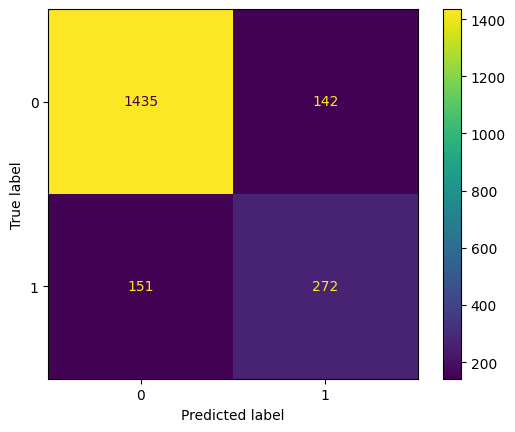

In [86]:
ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test)
plt.savefig('../images/Confusion_Matrix_model3.png', dpi=300, bbox_inches='tight')
plt.show()

Model Selection Verdict: The XGBoost model demonstrated the highest stability and balance, with all performance metrics falling between 64% and 66%:

- Precision: 66% (High reliability)

- Recall: 64% (Solid detection rate)

- F1-Score: 65% (Overall consistency)

This balance makes it the most viable option for solving the business problem. Furthermore, the ROC-AUC of 0.88 confirms its superior predictive power compared to the Random Forest model.

In this project, I evaluated three predictive models: Logistic Regression, Random Forest, and XGBoost.

The Logistic Regression model achieved the highest recall (75%) but proved to be too aggressive, resulting in low precision (40%) and a poor F1-score (52%). The model generated an excessive number of false alarms, which is inappropriate for this business case as it would incur significant unnecessary costs.

The Random Forest model performed better, offering a more balanced trade-off between precision (60%) and recall (66%). However, the XGBoost model emerged as the champion after hyperparameter tuning. It delivered the most robust and balanced metrics for the minority class (Precision: 66%, Recall: 64%, F1-score: 65%). Additionally, it achieved an ROC-AUC of 0.88, outperforming the other models and making it the optimal choice for the bank's retention strategy.

Feature Importance & Insights: Analysis revealed the key drivers of churn:

- Number of Products: This is the most critical factor. Clients with 3 or more products are highly prone to churn, whereas holding exactly 2 products significantly increases loyalty.

- Activity Status: The XGBoost model highlighted that inactive members are much more likely to leave, while active engagement acts as a retention buffer.

- Age: Older clients (specifically the 45-60 age group) show a higher tendency to resign.

Business Recommendation: Due to its high precision, the XGBoost model allows the bank to implement medium-to-high cost retention campaigns (e.g., financial incentives) without the risk of wasting budget on loyal customers. Strategic efforts should specifically target inactive clients aged 45+ who hold 3 or more products.